### Tests find_thymio/goal

Image dimensions are 815 x 615
Map corner: x: 610, y: 585
Map corner: x: 220, y: 580
Map corner: x: 252, y: 58
Map corner: x: 587, y: 53
Image center is (417.25, 319.0)
Top left (252, 58)
Top Right (587, 53)
Bottom left (220, 580)
Bottom right (610, 585)
Rectified image dimensions are 381 x 600


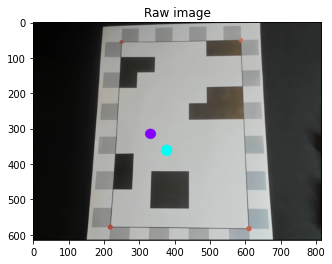

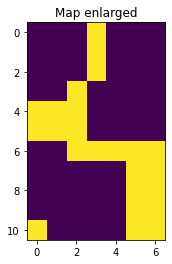

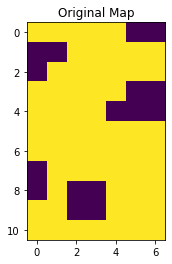

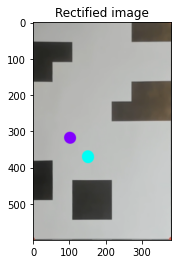

Thymio_pose [2.         6.         2.32650025]
Goal_coords []
Goal not found!


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os

import sys  
#sys.path

sys.path.insert(1, 'src')
sys.path.insert(1, 'img')

import create_map
import locate_thymio_goal
import img_utils

from create_map import *
from locate_thymio_goal import *
from img_utils import *



filename = 'img/speed_test1.png'
img = cv2.imread(filename, cv2.IMREAD_COLOR)

################################################IMG_CORRECTION////////////////////////////////////////////////////

# read image
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img, 7, 11, verbose = True)
if success:
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

[thymio_pose,thymio_found] = locate_thymio_camera(img_rect,'grid', [7,11])
[goal_coords,goal_found] = locate_goal_camera(img_rect,'grid', [7,11])


#hsv = cv2.cvtColor(img_rect, cv2.COLOR_BGR2HSV)
#hsv[270, 70]
#img[270,300]
print("Thymio_pose {}".format(thymio_pose))
print("Goal_coords {}".format(goal_coords))
if(thymio_found == 0):
    print("Thymio not found!")
if(goal_found == 0) :
    print("Goal not found!")


In [2]:
	## Returns speed of the thymio in pixel/s.
    #  @param rect_img1/2    Rectified images used in the speed calculation
    #  @param dt             Elapsed time between the two images were taken
    #  @param speed_type     string variable that can take 'x_y' or 'front_side'
    #                        'x_y' the function will return the speed in x_y coordinates
    #                        'front_side' the function will return the speed in front and side coordinates
	#  @return speed         [total_speed, x_speed,y_speed] or [total_speed, front_speed,side_speed],
    #                        speed of the thymio in pixels/s.
def get_thymio_speed_camera(old_rect_img,new_rect_img,dt,speed_type):
    [thymio_pose1,thymio_found] = locate_thymio_camera(old_rect_img,'cartesian', [7,11])
    [thymio_pose2,thymio_found] = locate_thymio_camera(new_rect_img,'cartesian', [7,11])
    
    
    distance = math.sqrt(pow(thymio_pose2[0]-thymio_pose1[0],2) + pow(thymio_pose2[1]-thymio_pose1[1],2))
    total_speed = distance/dt
    #SPEED CALCULATION IN PIXEL/S
    if (speed_type == 'x_y'):
        x_speed = (thymio_pose2[0]-thymio_pose1[0])/dt
        y_speed = (thymio_pose2[1]-thymio_pose1[1])/dt
        
        speed =[total_speed,x_speed,y_speed]
        
    else:
        total_movement = [thymio_pose2[0]-thymio_pose1[0] , thymio_pose2[1]-thymio_pose1[1]]
        #u vecteur unitaire dans la direction du thymio
        u = [math.cos(thymio_pose1[2]), -math.sin(thymio_pose1[2])]
        front_movement = np.multiply(np.dot(total_movement,u),u)
        side_movement = total_movement-front_movement
        
        front_speed = math.sqrt(pow(front_movement[0],2) + pow(front_movement[1],2))/dt
        side_speed = math.sqrt(pow(side_movement[0],2) + pow(side_movement[1],2))/dt
        speed =[total_speed,front_speed,side_speed]
        
    return speed

### Speed and speed ratio measurements.

In [4]:

from MyThymio import*
thymio = MyThymio()


In [14]:
#IMPORTS
import camera
import MyThymio
from camera import*
import time


#th = connect_to_thymio(num_err = 20, verbose = True)
#MyThymio__init__(th, 0)

thymio.set_motor_speeds(0,0)

#INITIALIZATION
MAP_WIDTH = 815
MAP_HEIGHT = 615
IMPUT_SPEED = 100

cam = init_camera(width = MAP_WIDTH, height = MAP_LENGTH)

prev_img, ret_val = take_picture(cam, video = 0)
t1 = time.time()
M, rect_width, rect_height, map, map_enlarged, success = create_map(new_img, 7, 11, 0)
prev_rect_img = get_rectified_img(prev_img, M, rect_width, rect_height)

thymio.set_motor_speeds(100,100)

sleep(5)

new_img = take_picture(cam, video = 0)
t2 = time.time()
new_rect_img = get_rectified_img(new_img, M, rect_width, rect_height)

thymio.set_motor_speeds(0,0)

dt = t2-t1

speed = get_thymio_speed(prev_rect_img,new_rect_img,dt,'x_y');
print("Thymio_speed {} pixels/s".format(speed))

#ratio speed(pixel)/speed(input)
ratio = speed/IMPUT_SPEED
print("Speed_ratio (speed(pixel)/speed(input)){}".format(ratio))


AttributeError: 'list' object has no attribute 'shape'

### Covariance Matrices:

In [19]:

##Measurement covariance matrix (R)

NB_DATAPOINTS = 50;
cam = init_camera(width = MAP_WIDTH, height = MAP_LENGTH)

#position (x,y) variance

thymio.set_motor_speeds(0,0)

thymio_x = []
thymio_y = []
for x in range(NB_DATAPOINTS):
    new_img, ret_val = take_picture(cam, video = 0) 
    M, rect_width, rect_height, map, map_enlarged, success = create_map(new_img, 7, 11, 0)
    new_img_rect = get_rectified_img(new_img, M, rect_width, rect_height)
    [new_thymio_pose,thymio_found] = locate_thymio_camera(new_img_rect,'cartesian', [7,11])
    thymio_x = np.append(thymio_x, new_thymio_pose[0])
    thymio_y = np.append(thymio_y, new_thymio_pose[1])
    sleep (0.05)
end

cov_xy_R = np.cov(thymio_x,thymio_y)

#other method for pos_cov: thymio_speed / sampling period =~ position error 

#speed_variance

prev_img = take_picture(cam, video = 0)
M, rect_width, rect_height, map, map_enlarged, success = create_map(prev_img, 7, 11, 0)
prev_img_rect = get_rectified_img(prev_img, M, rect_width, rect_height)
prev_time = time.time()

thymio.set_motor_speeds(IMPUT_SPEED,IMPUT_SPEED)

thymio_front_speed = []
thymio_side_speed = []
t = []
total_time = 0


for x in range(NB_DATAPOINTS):
    new_img, ret_val = take_picture(cam, video = 0)
    new_time = time.time()
    M, rect_width, rect_height, map, map_enlarged, success = create_map(new_img, 7, 11, 0)
    new_img_rect = get_rectified_img(new_img, M, rect_width, rect_height)
    dt = new_time-prev_time
    
    speed = thymio.get_thymio_speed(new_img,prev_img,dt,'front_side')
    
    
    thymio_front_speed = np.append(thymio_front_speed, speed[1])
    thymio_side_speed = np.append(thymio_side_speed, speed[2])
    total_time = total_time + dt
    t = np.append(t, total_time)
    
    sleep (0.1)
    prev_img_rect = new_img_rect
    prev_time = new_time
end

cov_speed_front_side = np.cov(thymio_front_speed,thymio_side_speed)

print('valeurs constantes de la matrice de cov en mesure:')
print('covariance de la mesure en position {}\ncovariance de la mesure en vitesse \n{}'.format(cov_xy_R,cov_speed_front_side))
print('la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant l exprimer en fct des axes x et y')
#We then need to convert this values in x_y coordinates

#pos,angle = get_last_position(th)
angle = 30*math.pi/180 #example

Rotation = [[math.cos(angle),-math.sin(angle)],[math.sin(angle),math.cos(angle)]]
cov_speed_xy = np.dot(np.dot(Rotation,cov_speed_front_side),np.transpose(Rotation))



#we assume that half the error observed is due to the measurements (the other half is generated by perturbations to the states)
cov_speed_xy_R = np.multiply(cov_speed_xy,0.5)
cov_speed_xy_Q = np.multiply(cov_speed_xy,0.5)

R1 = np.append(cov_xy_R[0],[0,0])
R2 = np.append(cov_xy_R[1],[0,0])
R3 = np.append([0,0],cov_speed_xy_R[0])
R4 = np.append([0,0],cov_speed_xy_R[1])
R = [R1,R2,R3,R4]

print('\nMatrice de covariance pour la mesure(R):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(R,1)))

#we choose arbitrarly a std of the position state of 0.1 pixel. (var_x and var_y = 0.01)  

cov_xy_Q = [[0.01,0],[0,0.01]]

Q1 = np.append(cov_xy_Q[0],[0,0])
Q2 = np.append(cov_xy_Q[1],[0,0])
Q3 = np.append([0,0],cov_speed_xy_Q[0])
Q4 = np.append([0,0],cov_speed_xy_Q[1])
Q = [Q1,Q2,Q3,Q4]
 
print('matrice de covariance de l état(Q):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(Q,1)))


AttributeError: 'list' object has no attribute 'shape'

### Tests

In [ ]:
a = [1,2]
b = [2,-1]

c = [a[0]-b[0],a[1]-b[1]]
np.dot(a,b)
d = np.multiply(a,np.dot(a,b))
print(d)

print(np.cov(a,b))

[203.85534086699815, 201.93760731400783, 27.89628563614838]

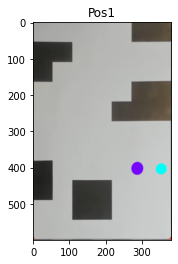

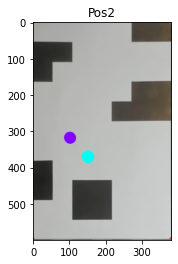

In [16]:

old_img = cv2.imread('img/speed_test3.png', cv2.IMREAD_COLOR)
old_rect_img = get_rectified_img(old_img, M, rect_width, rect_height)
plt.figure()
plt.imshow(cv2.cvtColor(old_rect_img, cv2.COLOR_BGR2RGB))
plt.title("Pos1")

new_img = cv2.imread('img/speed_test1.png', cv2.IMREAD_COLOR)
new_rect_img = get_rectified_img(new_img, M, rect_width, rect_height)
plt.figure()
plt.imshow(cv2.cvtColor(new_rect_img, cv2.COLOR_BGR2RGB))
plt.title("Pos2")

dt = 1

get_thymio_speed_camera(old_rect_img,new_rect_img,dt,'front_side')

In [17]:
A =[[1,3],[2,3]]
print(A)

B = [[2,1],[1,8]]

C1 = np.append(A[0],[0,0])
C2 = np.append(A[1],[0,0])
C = [C1,C2]

print(C)

D = np.multiply(C,1)
print('D{} \n A{}'.format(D,A))
print('la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant lexprimer en fct des axes x et y')

[[1, 3], [2, 3]]
[array([1, 3, 0, 0]), array([2, 3, 0, 0])]
D[[1 3 0 0]
 [2 3 0 0]] 
 A[[1, 3], [2, 3]]
la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant lexprimer en fct des axes x et y


In [18]:
cov_xy_R = [[0,0],[0,0]]

thymio_front_speed = [10.1, 10, 10, 10,10.1,9.95,10,10,10.1 ]
thymio_side_speed = [0,  0.01,0, 0, 0.01,0,0,-0.03,0.006]


cov_speed_front_side = np.cov(thymio_front_speed,thymio_side_speed)

print('valeurs constantes de la matrice de cov en mesure:')
print('covariance de la mesure en position {}\ncovariance de la mesure en vitesse \n{}'.format(cov_xy_R,cov_speed_front_side))
print('la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant l exprimer en fct des axes x et y')
#We then need to convert this values in x_y coordinates

#pos,angle = get_last_position(th)
angle = 30*math.pi/180 #example

Rotation = [[math.cos(angle),-math.sin(angle)],[math.sin(angle),math.cos(angle)]]
cov_speed_xy = np.dot(np.dot(Rotation,cov_speed_front_side),np.transpose(Rotation))



#we assume that half the error observed is due to the measurements (the other half is generated by perturbations to the states)
cov_speed_xy_R = np.multiply(cov_speed_xy,0.5)
cov_speed_xy_Q = np.multiply(cov_speed_xy,0.5)

R1 = np.append(cov_xy_R[0],[0,0])
R2 = np.append(cov_xy_R[1],[0,0])
R3 = np.append([0,0],cov_speed_xy_R[0])
R4 = np.append([0,0],cov_speed_xy_R[1])
R = [R1,R2,R3,R4]

print('\nMatrice de covariance pour la mesure(R):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(R,1)))

#we choose arbitrarly a std of the position state of 0.1 pixel. (var_x and var_y = 0.01)  

cov_xy_Q = [[0.01,0],[0,0.01]]

Q1 = np.append(cov_xy_Q[0],[0,0])
Q2 = np.append(cov_xy_Q[1],[0,0])
Q3 = np.append([0,0],cov_speed_xy_Q[0])
Q4 = np.append([0,0],cov_speed_xy_Q[1])
Q = [Q1,Q2,Q3,Q4]
 
print('matrice de covariance de l état(Q):\n{}\n(dans cet exemple angle = 30degrés)'.format(np.multiply(Q,1)))

valeurs constantes de la matrice de cov en mesure:
covariance de la mesure en position [[0, 0], [0, 0]]
covariance de la mesure en vitesse 
[[0.00319444 0.00021389]
 [0.00021389 0.00014178]]
la covariance en vitesse est exprimée en fonction de l orientation du thymio, il faut maintenant l exprimer en fct des axes x et y

Matrice de covariance pour la mesure(R):
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.00112302 0.00071439]
 [0.         0.         0.00071439 0.00054509]]
(dans cet exemple angle = 30degrés)
matrice de covariance de l état(Q):
[[0.01       0.         0.         0.        ]
 [0.         0.01       0.         0.        ]
 [0.         0.         0.00112302 0.00071439]
 [0.         0.         0.00071439 0.00054509]]
(dans cet exemple angle = 30degrés)
